In [41]:
import numpy as np
from numpy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-white')
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm

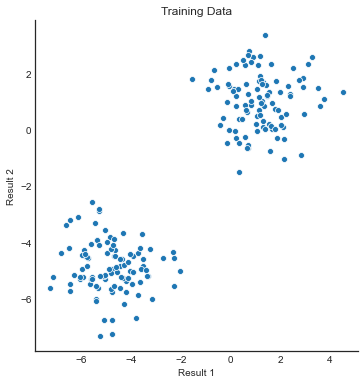

In [2]:
#Read sample data for GMM analysis
test_data = pd.read_excel('Data_GMM.xlsx')
n_arr = test_data.to_numpy()
f = sns.pairplot(x_vars=['Result 1'], y_vars=['Result 2'], data=test_data, height=5)
plt.title('Training Data')
plt.savefig('raw_data_GMM.png',dpi=150,bbox_inches='tight')

In [3]:
# Create the required log likelihood function to perform GMM anaysis.
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [40]:
# Develop Expectation Maximization algorithm for GMM to iterate till convergence happens.
def GMM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in tqdm(range(maxiter)):
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        for j in range(num_data):
            for k in range(num_clusters):
                resp[j, k] = weights[k]*multivariate_normal.pdf(data[j],means[k],covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            weights[k] = counts[k]/num_data
            # Update means for cluster k using the M-step update rule for the mean variables.
            weighted_sum = 0
            for j in range(num_data):
                weighted_sum += (resp[j,k]*data[j])
            means[k] = weighted_sum/counts[k]
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                weighted_sum += (resp[j,k]*np.outer(data[j]-means[k],data[j]-means[k]))
            covariances[k] = weighted_sum/counts[k]
          
        
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}
    print('Convergence achieved in '+str(i)+' iterations')
    return out

In [39]:
np.random.seed(4)

# Initialization of the parameters in a randomised manner.
n_classes = 2
chosen = np.random.choice(len(n_arr),n_classes, replace=False)
initial_means = [n_arr[x] for x in chosen]
initial_covs = [np.cov(n_arr, rowvar=0)] * n_classes
initial_weights = [1/(n_classes)] * n_classes

# Run GMM 
results = GMM(n_arr, initial_means, initial_covs, initial_weights,maxiter=1000)
print('GMM Cluster Centres are located at: '+str(results['means'][0])+' and '+str(results['means'][1]))


Convergence achieved in 528 iterations
GMM Cluster Centres are located at: [-4.81815103 -4.87158388] and [1.19721315 1.00893775]


In [17]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))


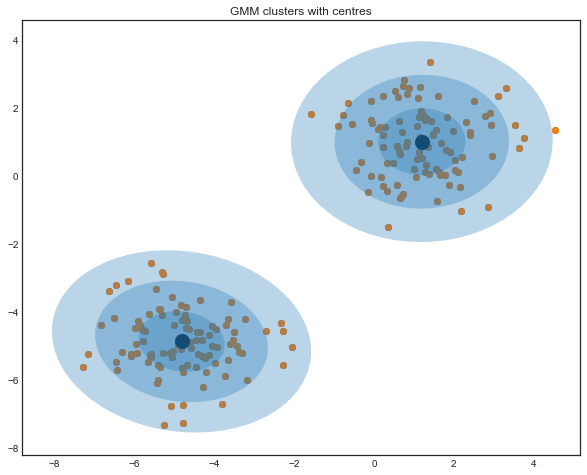

In [37]:
#Plot the clusters.
plt.figure(figsize = (10,8))
plt.scatter(n_arr[:, 0], n_arr[:, 1])
plt.scatter(n_arr[:, 0], n_arr[:, 1])
centers = np.zeros((2,2))
for pos, covar, w in zip(results['means'], results['covs'], results['weights']):
    draw_ellipse(pos, covar, alpha=0.3)
for i in range (n_classes):
    plt.scatter(results['means'][i].item(0),results['means'][i].item(1),c='black',s=200,alpha = 1)
plt.title('GMM clusters with centres')
plt.savefig('clusters_GMM.png',dpi=150,bbox_inches='tight')